# <font color='green'>Homework 2</font>

<div class="alert alert-block alert-warning">
<b>
University of Tehran<br>
Fall 2022<br>
Course: Interactive Learning<br>
</div>


***

<div class="alert alert-block alert-success">
<b>Author:</b><br>
Name: Taban Soleymani <br />
Student Number: 
</div>

***

# <span style="color:purple">Importing Required Packages and Classes</span>

In [27]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt

# <span style="color:purple">Defining Variables</span>

In [28]:
global num_of_actions
global best_reward
global num_of_trials
global num_of_runs
global epsilon
global learning_rate
global c
num_of_actions = 3
best_reward = 5
num_of_trials = 100
num_of_runs = 20
epsilon = 0.2
learning_rate = 0.001
c = 2

# <span style="color:purple">Part 2</span>

## <span style="color:purple">Reward Class</span>

In [29]:
class Reward(ABC):
    def __init__(self, debts=[5.0, 20.0, 100.0]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [30]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1])
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05])
        
        return obs, obs - self.debts[action]

In [31]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, obs - self.debts[action]

In [32]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, obs - self.debts[action]

## <span style="color:purple">Environment</span>

In [33]:
class Environment(gym.Env, ABC):
    
    def __init__(self, id, reward):
        super(Environment, self).__init__()
        self.id = id
        self.action_space = gym.spaces.Discrete(num_of_actions)
        self.reward = reward
    
    @abstractmethod
    def calc_reward(self, action):
        pass
            
        
    def get_available_actions(self):
        return np.arange(0,num_of_actions)

In [34]:
class StudentEnv(Environment):
    
    def __init__(self, id, reward):
        super(StudentEnv, self).__init__(id, reward)
    
    
    def calc_reward(self, action):
        student = Student()
        
        if action == 0: # student with loan principal amount of 5 million tomans
            _ , reward_in_step = student.get_reward(0)
        elif action == 1: # student with loan principal amount of 20 million tomans
            _ , reward_in_step = student.get_reward(1)
        else: # student with loan principal amount of 100 million tomans
            _ , reward_in_step = student.get_reward(2)
     
        return reward_in_step 

In [35]:
class GovStaffEnv(Environment):
    
    def __init__(self, id, reward):
        super(GovStaffEnv, self).__init__(id, reward)
    
    
    def calc_reward(self, action):
        gov_staff = GovStaff()
        
        if action == 0: # government staff with loan principal amount of 5 million tomans
            _ , reward_in_step = gov_staff.get_reward(0)
        elif action == 1: # government staff with loan principal amount of 20 million tomans
            _ , reward_in_step = gov_staff.get_reward(1)
        else: # government staff with loan principal amount of 100 million tomans
            _ , reward_in_step = gov_staff.get_reward(2)
     
        return reward_in_step 

In [36]:
class SelfEmpEnv(Environment):
    
    def __init__(self, id, reward):
        super(SelfEmpEnv, self).__init__(id, reward)
    
    
    def calc_reward(self, action):
        self_employed = SelfEmp()
        
        if action == 0: # self-employed with loan principal amount of 5 million tomans
            _ , reward_in_step = self_employed.get_reward(0)
        elif action == 1: # self-employed with loan principal amount of 20 million tomans
            _ , reward_in_step = self_employed.get_reward(1)
        else: # self-employed with loan principal amount of 100 million tomans
            _ , reward_in_step = self_employed.get_reward(2)
     
        return reward_in_step 

# <span style="color:purple">Part 3</span>

## <span style="color:purple">Agent</span>

In [37]:
class Agent(ABC):
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1):
        super(Agent, self).__init__()
        self.id = _id
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.current_trial = 0
        self.instant_rewards = []
        self.instant_regrets = []
        self.actions = []
        self.utilities = [0] * len(self.env.get_available_actions())
    
    
    @abstractmethod
    def choose_action(self):
        pass
    
    
    def calculate_utility(self, reward):
        utility = self.beta * (reward ** self.gamma) + self.alpha
        return utility
    
    
    def take_action(self, action):
        reward = self.env.calc_reward(action)
        util = self.calculate_utility(reward)
        self.update_value(action, util)
        self.instant_rewards.append(reward)
        self.actions.append(action)
    
    
    @abstractmethod
    def update_value(self, action, util):
        pass

    
    @abstractmethod
    def step(self, best_reward, trial):
        pass

    
    def reset(self):
        self.instant_rewards = []
        self.instant_regrets = []
        self.actions = []
        self.utilities = [0] * len(self.env.get_available_actions())
    
    
    def get_rewards(self):
        return self.instant_rewards
    
    
    def get_regrets(self):
        u_starrred_a_starred = max(self.utilities)
        for i in range(self.current_trial + 1):
            regret_per_run_till_h = i * u_starrred_a_starred - sum(self.instant_rewards[0:i])
            # print(regret_per_run_till_h)
            self.instant_regrets.append(regret_per_run_till_h)
        return self.instant_regrets

In [38]:
class EpsilonGreedy(Agent):
    
    def __init__(self, _id, env, epsilon):
        super(EpsilonGreedy, self).__init__(_id, env)
        self.epsilon = epsilon
        self.num_of_times_explored = 0
        self.num_of_times_exploited = 0
      
    
    def choose_action_randomly(self):
        # choosing random actions based on available actions of each environments 
        available_actions = self.env.get_available_actions()
        available_actions_length = len(available_actions)
        given_value = 1 / available_actions_length
        available_actions_probabilities = [given_value] * available_actions_length
        random_action = np.random.choice(available_actions, p=available_actions_probabilities)
        return random_action
    
    
    def choose_action(self):
        if np.random.random() < self.epsilon:
            self.num_of_times_explored += 1
            action = self.choose_action_randomly()
        else:
            self.num_of_times_exploited += 1
            available_actions = self.env.get_available_actions()
            max_item = max(self.utilities)
            result = self.utilities.index(max_item)
            action = available_actions[result]
        return action
    
    
    def update_value(self, action, util):
        alpha = 1 / (self.current_trial + 1)
        self.utilities[action] = self.utilities[action] + alpha * (util - self.utilities[action])
        
        
    def step(self, best_reward, trial):
        self.current_trial = trial
        if trial == 0:
            self.reset()
            initial_action = self.choose_action_randomly()
            self.take_action(initial_action)
        else:
            action = self.choose_action()
            self.take_action(action)

In [39]:
from math import exp 

class GradientBandit(Agent):
    def __init__(self, _id, env, learning_rate):
        super(GradientBandit, self).__init__(_id, env)
        self.learning_rate = learning_rate
    
    
    def choose_action(self):
        available_actions = self.env.get_available_actions()
        available_actions_length = len(available_actions)
        available_actions_probabilities = []
        for i in range(0, available_actions_length):
            H_a = self.utilities[i]
            p_a = exp(H_a) / sum(np.exp(self.utilities))
            available_actions_probabilities.append(p_a)
        action = np.random.choice(available_actions, p=available_actions_probabilities)
        return action
    
    
    def step(self, best_reward, trial):
        self.current_trial = trial
        if trial == 0:
            self.reset()

        action = self.choose_action()
        self.take_action(action)
    
    
    def update_value(self, action, util):
        max_util = max(self.utilities)
        max_util_index = self.utilities.index(max_util)
        H_a = self.utilities[action]
        p_a = exp(H_a) / sum(np.exp(self.utilities))
        if len(self.instant_rewards) != 0:
            if action == max_util_index:
                self.utilities[action] = self.utilities[action] + self.learning_rate * (util - self.utilities[action]) * (1 - p_a)
            else:
                self.utilities[action] = self.utilities[action] + self.learning_rate * (util - self.utilities[action]) * p_a

In [40]:
import math

class UCB(Agent):
    def __init__(self, _id, env, c):
        super(UCB, self).__init__(_id, env)
        self.c = c
        self.ucb = [1e400] * len(self.env.get_available_actions())
    
    
    def choose_action(self):
        available_actions = self.env.get_available_actions()
        max_ucb_item = max(self.ucb)
        index_of_max_ucb_item = self.ucb.index(max_ucb_item)
        action = available_actions[index_of_max_ucb_item]
        return action
    
    
    def take_action(self, action):
        reward = self.env.calc_reward(action)
        util = self.calculate_utility(reward)
        self.update_value(action, util)
        np_actions = np.array(self.actions)
        numbers_of_selections = len(np_actions[np_actions == action])
        self.update_ucb(action, numbers_of_selections + 1)
        self.instant_rewards.append(reward)
        self.actions.append(action)
    
    
    def update_ucb(self, action, numbers_of_selections):
        self.ucb[action] = self.utilities[action] + self.c * (math.sqrt(2 * math.log(self.current_trial+1) / numbers_of_selections))
    
    
    def step(self, best_reward, trial):
        self.current_trial = trial
        if trial == 0:
            self.reset()

        action = self.choose_action()
        self.take_action(action)

    
    def reset(self):
        self.instant_rewards = []
        self.instant_regrets = []
        self.actions = []
        self.utilities = [0] * len(self.env.get_available_actions())
        self.ucb = [1e400] * len(self.env.get_available_actions())
    
    
    def update_value(self, action, util):
        alpha = 1 / (self.current_trial + 1)
        self.utilities[action] = self.utilities[action] + alpha * (util - self.utilities[action])

# <span style="color:purple">Part 4</span>

## <span style="color:purple">Util Functions</span>

In [41]:
def calculate_average_rewards_and_regrets_per_run(agent):
    
    avg_rewards = np.array([0] * num_of_trials)
    avg_regrets = np.array([0] * num_of_trials)

    for run in range(0, num_of_runs):
        for trial in range(0, num_of_trials):
            agent.step(best_reward, trial)
        avg_rewards = np.add(avg_rewards, np.array(agent.get_rewards()))
        avg_regrets = np.add(avg_regrets, np.array(agent.get_regrets()))
            
    return avg_rewards * (1 / num_of_runs), avg_regrets * (1 / num_of_runs)

In [42]:
def plot_y_per_trials(e_greedy_y, gradient_based_y, ucb_y, y_label, env_name):
    trials = np.arange(num_of_trials)
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(trials, e_greedy_y, color='b', label='Epsilon Greedy')
    plt.plot(trials, gradient_based_y, color='g', label='Gradient Based')
    plt.plot(trials, ucb_y, color='r', label='Upper Confidence Bound')
    plt.title(env_name)
    plt.xlabel('Trials')
    plt.ylabel(y_label)
    plt.grid()
    plt.legend()
    plt.show()

In [43]:
def plot_average_rewards_and_regrets_per_trial(env, env_name):

    e_greedy_agent = EpsilonGreedy(1, env, epsilon)
    gradient_based_agent = GradientBandit(1, env, learning_rate)
    ucb_agent = UCB(1, env, c)

    e_greedy_avg_rewards, e_greedy_avg_regrets = calculate_average_rewards_and_regrets_per_run(e_greedy_agent)
    gradient_avg_rewards, gradient_avg_regrets = calculate_average_rewards_and_regrets_per_run(gradient_based_agent)
    ucb_avg_rewards, ucb_avg_regrets = calculate_average_rewards_and_regrets_per_run(ucb_agent)

    # rewards
    plot_y_per_trials(e_greedy_avg_rewards, gradient_avg_rewards, ucb_avg_rewards, 'Rewards', env_name)
    
    # regrets
    plot_y_per_trials(e_greedy_avg_regrets, gradient_avg_regrets, ucb_avg_regrets, 'Regrets', env_name)

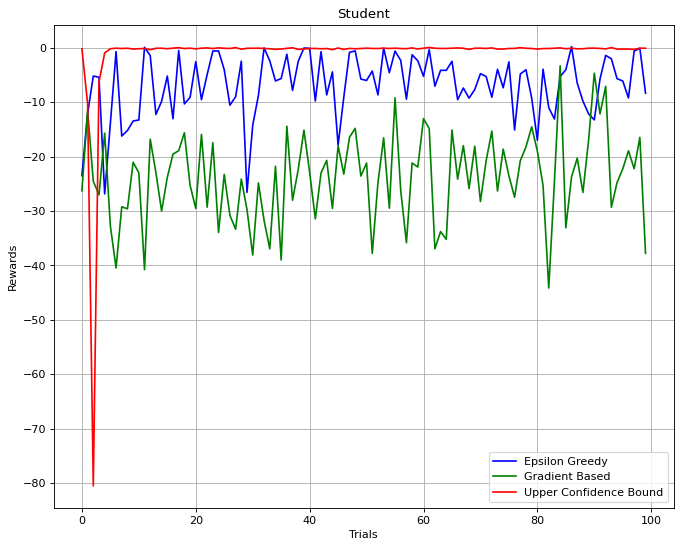

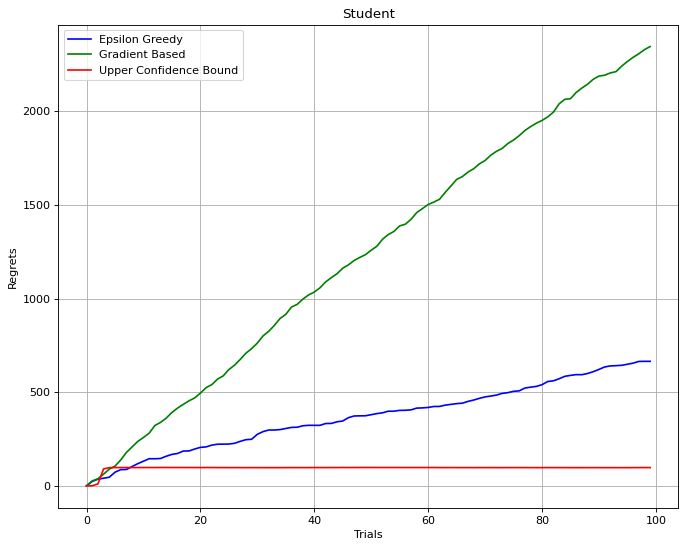

In [44]:
# in student env using epsilon-greedy, gradient bandit and ucb agent

student_env = StudentEnv(1, 0)

plot_average_rewards_and_regrets_per_trial(student_env, 'Student')

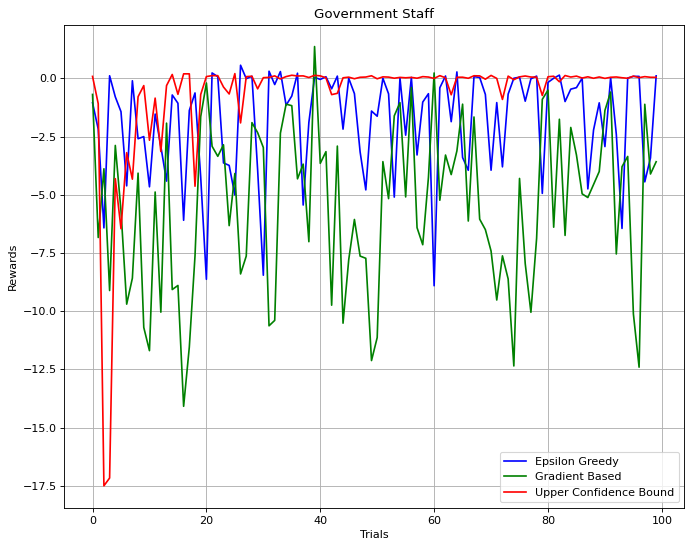

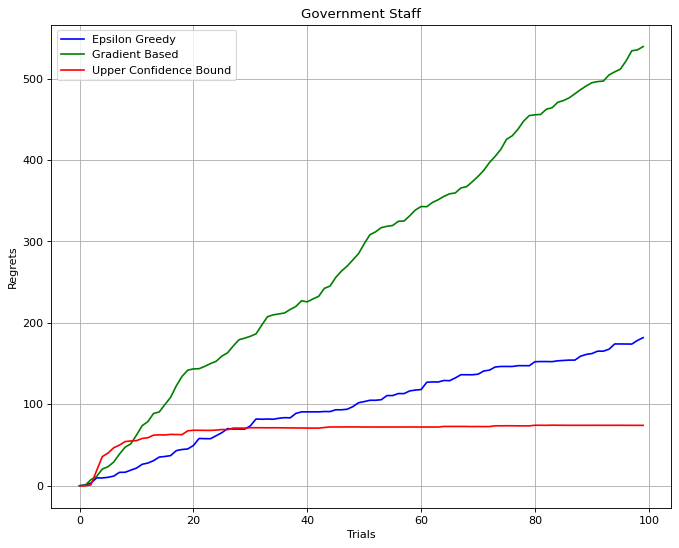

In [45]:
# in government staff env using epsilon-greedy, gradient bandit and ucb agent

gov_staff_env = GovStaffEnv(1, 0)

plot_average_rewards_and_regrets_per_trial(gov_staff_env, 'Government Staff')

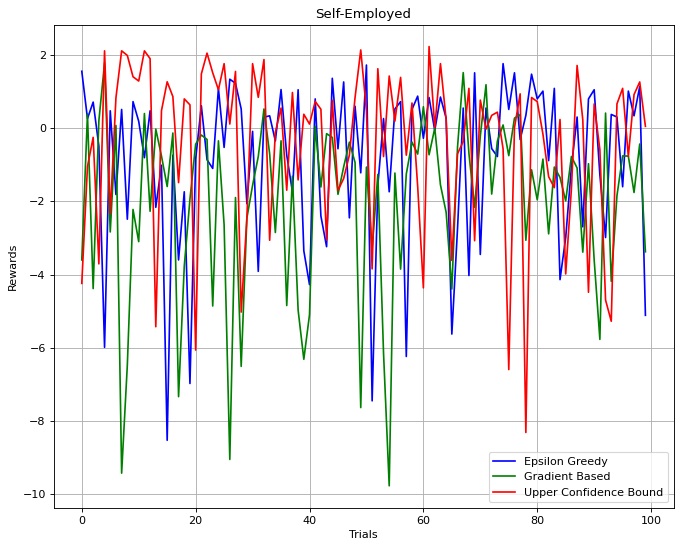

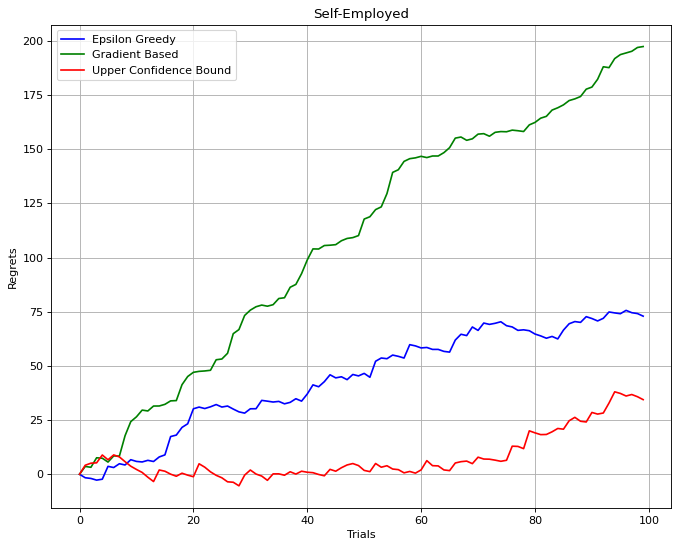

In [46]:
# in self-employment env using epsilon-greedy, gradient bandit and ucb agent

self_emp_env = SelfEmpEnv(1, 0)

plot_average_rewards_and_regrets_per_trial(self_emp_env, 'Self-Employed')

# <span style="color:purple">Part 5</span>

## <span style="color:purple">Util Functions</span>

In [47]:
def plot_y_per_trials_for_gradient_based_bandit(gradient_based_y0, gradient_based_y1, 
                                                gradient_based_y2, gradient_based_y3,
                                                y_label, env_name, lr):
    label_format = 'gradient-based for {learning_rate}'
    trials = np.arange(num_of_trials)
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(trials, gradient_based_y0, color='b', label=label_format.format(learning_rate=lr[0]))
    plt.plot(trials, gradient_based_y1, color='g', label=label_format.format(learning_rate=lr[1]))
    plt.plot(trials, gradient_based_y2, color='r', label=label_format.format(learning_rate=lr[2]))
    plt.plot(trials, gradient_based_y3, color='y', label=label_format.format(learning_rate=lr[3]))
    plt.title(env_name)
    plt.xlabel('Trials')
    plt.ylabel(y_label)
    plt.grid()
    plt.legend()
    plt.show()

In [48]:
def plot_average_rewardsNregrets_for_gradient_based_bandit(env, env_name, lr):

    gradient_based_agent0 = GradientBandit(1, env, lr[0])
    gradient_based_agent1 = GradientBandit(1, env, lr[1])
    gradient_based_agent2 = GradientBandit(1, env, lr[2])
    gradient_based_agent3 = GradientBandit(1, env, lr[3])

    gradient0_avg_rewards, gradient0_avg_regrets = calculate_average_rewards_and_regrets_per_run(gradient_based_agent0)
    gradient1_avg_rewards, gradient1_avg_regrets = calculate_average_rewards_and_regrets_per_run(gradient_based_agent1)
    gradient2_avg_rewards, gradient2_avg_regrets = calculate_average_rewards_and_regrets_per_run(gradient_based_agent2)
    gradient3_avg_rewards, gradient3_avg_regrets = calculate_average_rewards_and_regrets_per_run(gradient_based_agent3)

    # rewards
    plot_y_per_trials_for_gradient_based_bandit(gradient0_avg_rewards, gradient1_avg_rewards, gradient2_avg_rewards, 
                      gradient3_avg_rewards, 'Rewards', env_name, lr)
    
    # regrets
    plot_y_per_trials_for_gradient_based_bandit(gradient0_avg_regrets, gradient1_avg_regrets, gradient2_avg_regrets, 
                      gradient3_avg_regrets, 'Regrets', env_name, lr)

In [53]:
lr = [0.001, 0.1, 0.5, 1]
num_of_trials = 100

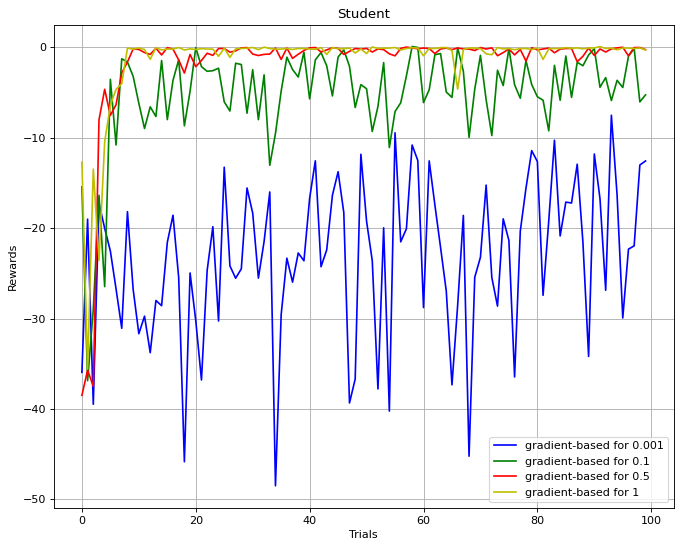

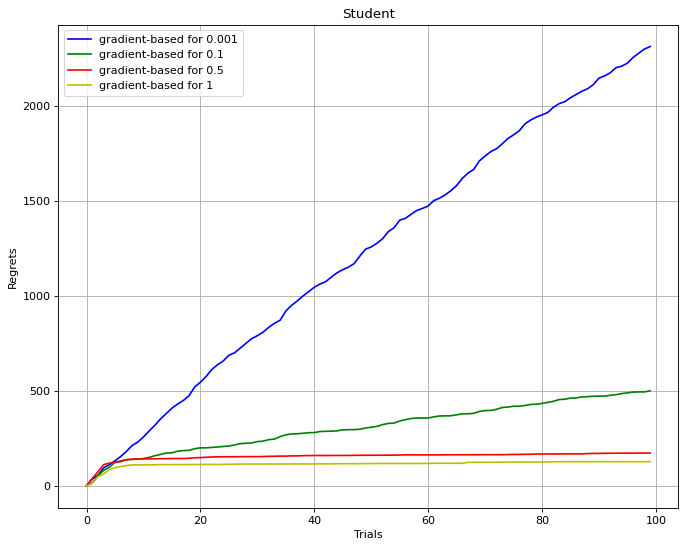

In [54]:
student_env = StudentEnv(1, 0)

plot_average_rewardsNregrets_for_gradient_based_bandit(student_env, 'Student', lr)

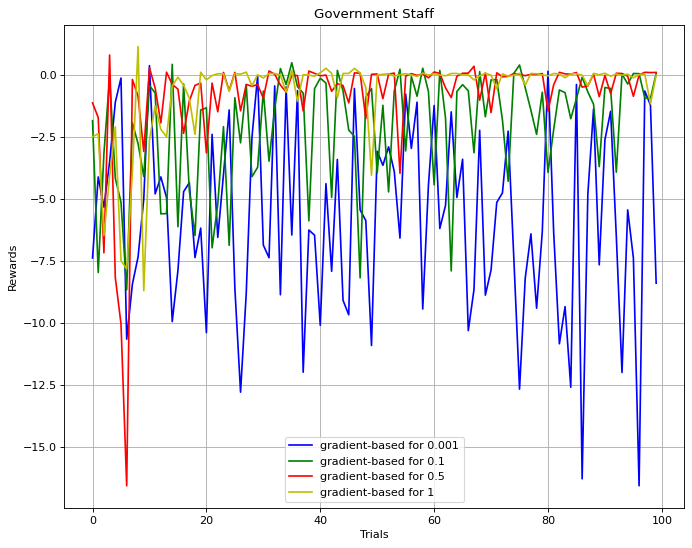

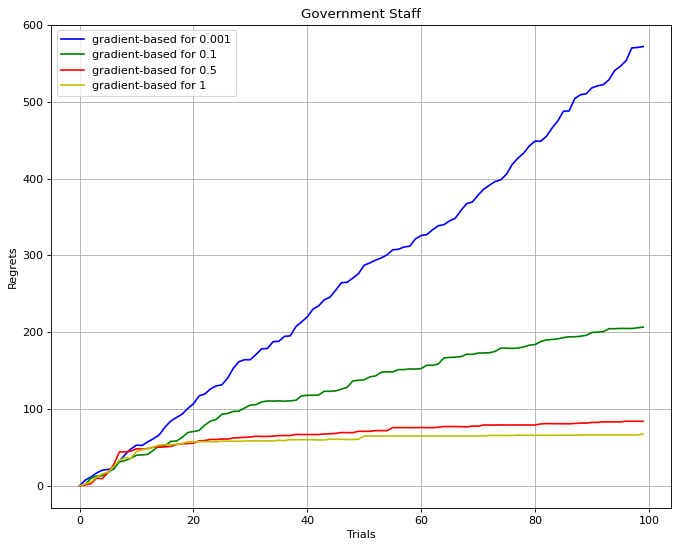

In [55]:
gov_staff_env = GovStaffEnv(1, 0)

plot_average_rewardsNregrets_for_gradient_based_bandit(gov_staff_env, 'Government Staff', lr)

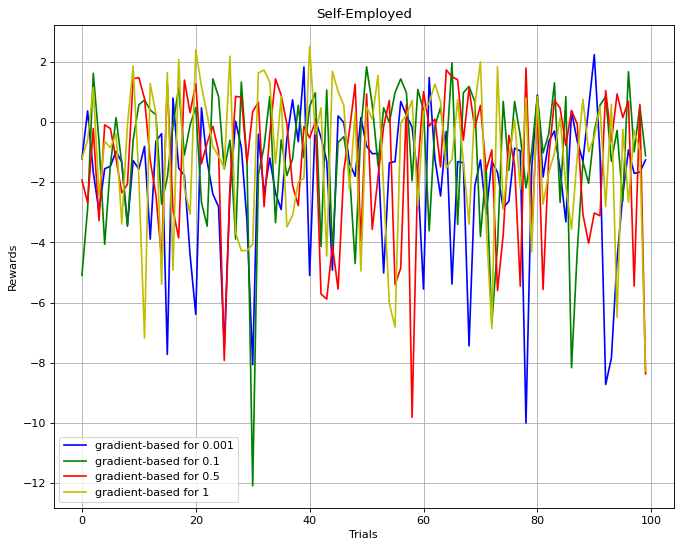

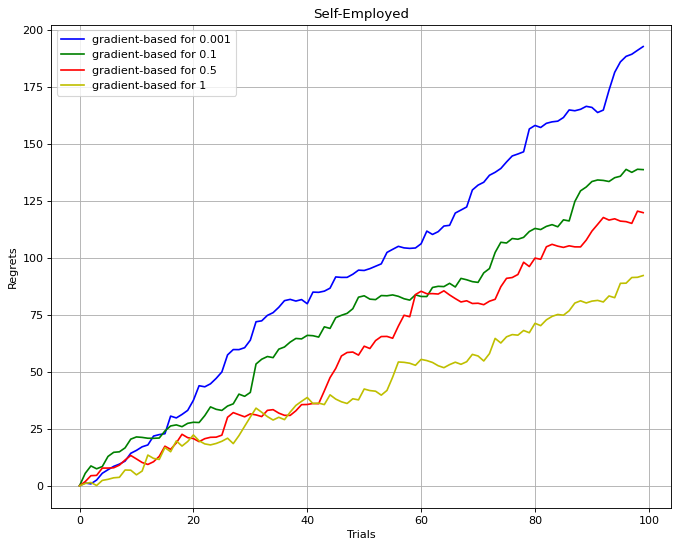

In [57]:
self_emp_env = SelfEmpEnv(1, 0)

plot_average_rewardsNregrets_for_gradient_based_bandit(self_emp_env, 'Self-Employed', lr)